 # Exercise 1: K-Means clustering

In this exercise you will implement your own k-means clustering algorithm using the famous "Iris" dataset.

The Iris dataset has the following measurements made on Iris flowers:

- Sepal length

- Sepal width

- Pedal length

- Pedal width

As well as a species label which is either Versicolor Setosa, or Virginica.

!["Irisflowers"](images/iris-flowers.png)


Can you cluster the flowers without knowing their species beforehand? How do you think your clustering will compare to the true species labels?

In this exercise you will get to implement a classical clustering algorithm called k-means.

The algorithm has a single hyperparameter "k", controlling the number of clusters. You can initialize the cluster centres randomly from a standard normal distribution

$X_c^{lm} \sim \mathcal{N}(0,1)$

where $X_c^{lm}$ is the lth coordinate of the m'th cluster centre.

You should then iteratively improve your clustering:

- Step 1: Assign all points in the dataset to a label corresponding to the nearest cluster centre. You can use Euclidean distance to determine which cluster is closest.
- Step 2: Set each cluster centre to be the centroid/mean of all points within the cluster.

Repeat Steps 1 and 2 until the distances between successive cluster centres become smaller than a tolerance, or the algorithm reaches a predetermined number of iterations.

Hint: In Step 1 you can use the following formula for the distance matrix $D$

$D_{ik} = \sqrt{\sum_j (X_c^{ij} - X^{kj})^2}$

where $j$ is the index of the data dimension (4 for our dataset), $k$ the index for the data point number (i.e. rows in the dataframe), and $i$ the index of the k cluster centres. 

Once you have the matrix $D$, you can use the numpy "argmin" function along the data point axis to get the cluster label corresponding to the closest cluster centre for each data point.   

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
plt.style.use("fivethirtyeight")

#imfeatures = pd.read_csv("data/LGE_MRI_features.csv")
iris_data = pd.read_csv("data/iris/iris.csv")
iris_data = iris_data.drop(columns = ["species"])

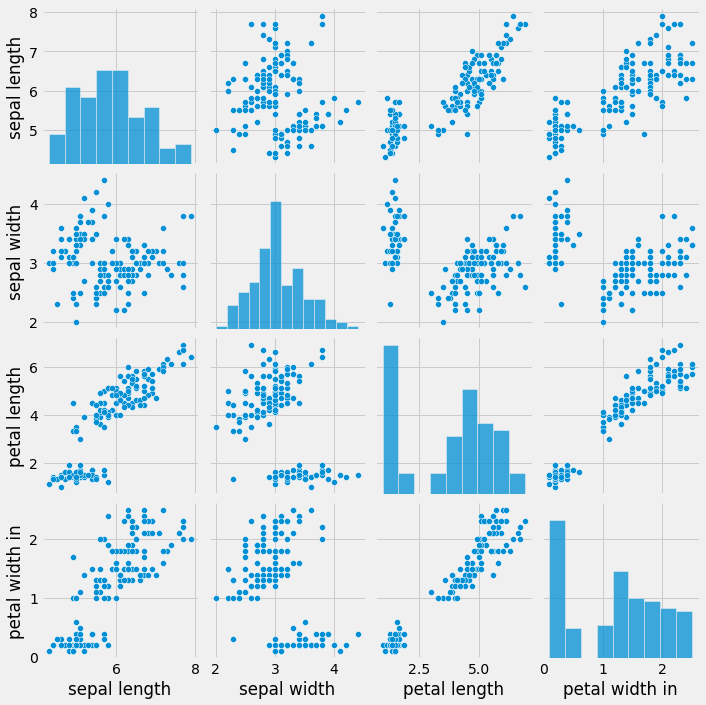

In [2]:
#Do you see any clusters yet?
sns.pairplot(iris_data)

It is very common to rescale your features before applying machine learning. If you look at the data above you will see that the measurements have different scales. If you do not rescale you will have problems when doing Euclidean distance calculations (what kind of problems?), which you will need to do in the k-means clustering algorithm.

In the cell below you should rescale all data to a standard Normal(0,1) distribution.

In [3]:
#Standardize the features to improve the k-means algorithm
iris_data_std = (iris_data - iris_data.mean())/iris_data.std()
iris_data_std

,sepal length,sepal width,petal length,petal width in
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593
2,-1.380727,0.336720,-1.393470,-1.308593
3,-1.501490,0.106090,-1.280118,-1.308593
4,-1.018437,1.259242,-1.336794,-1.308593
...,...,...,...,...
145,1.034539,-0.124540,0.816888,1.443121
146,0.551486,-1.277692,0.703536,0.918985
147,0.793012,-0.124540,0.816888,1.050019
148,0.430722,0.797981,0.930239,1.443121


In [4]:
class MyKMeans(object):
    def __init__ (self,
                  k= 2,
                  max_iter = 300,
                  convthresh=1e-3,
                  randstate = 42):
        
        self.k = k
        self.max_iter = max_iter
        self.convthresh = convthresh
        self.randstate = randstate
    
    def fit(self, data):
        self.data = data
        dims = len(data.columns)        
        
        r = np.random.RandomState(self.randstate)
        self.centres = r.normal(size = (self.k, dims))
        
        mean_update = self.convthresh + 1
        
        i = 0
        while mean_update > self.convthresh:
            self.labels = self.assign_labels(data.values, self.centres)
            
            new_centres = self.get_centres(data, self.labels)
            
            mean_update = np.linalg.norm(new_centres - self.centres)/len(self.centres)
            self.centres = new_centres
            
            if i > self.max_iter:
                raise Exception("Number of iterations exceeded {}".format(self.max_iter))
            
    def assign_labels(self, data, centres):
        D = np.sqrt(np.sum(np.square(centres[:,np.newaxis] - data), 
                               axis = 2))
        return D.argmin(axis = 0)
    
    def get_centres(self, data, labels):
        new_centres = []
        for label in range(self.k):
            in_label = label == labels
                
                #Some clusters might end up becoming empty 
                #In that case just copy over old cluster centre
            if in_label.sum() > 0:
                new_centres.append((data[in_label]).mean(axis = 0).values)
            else:
                new_centres.append(self.centres[label])
        return np.array(new_centres)

Run your algorithm with 3 clusters so you can compare to the real species labels shown below

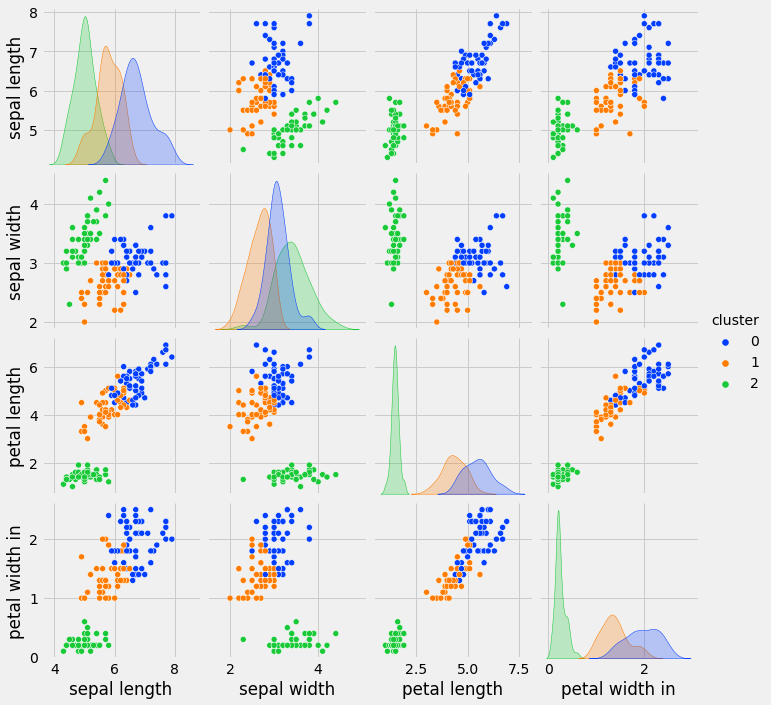

In [5]:
kmeans = MyKMeans(k = 3)
kmeans.fit(iris_data_std)

iris_data_clust = iris_data.copy()
iris_data_clust["cluster"] = kmeans.labels
sns.pairplot(iris_data_clust, hue = "cluster", palette = "bright")

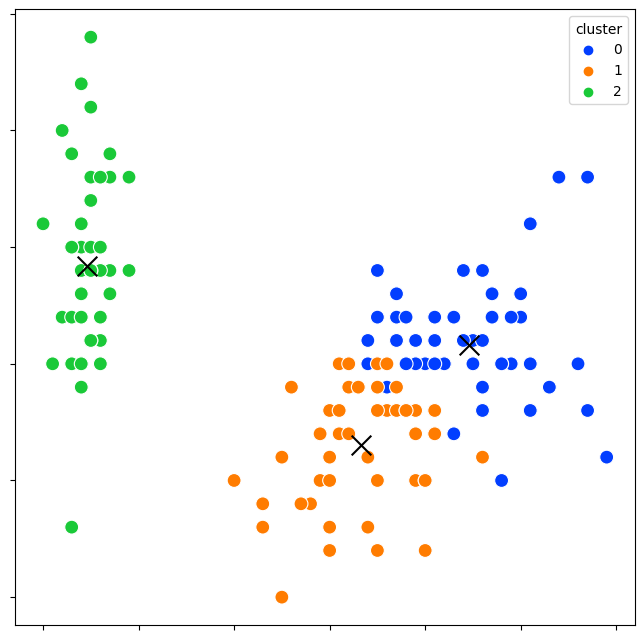

In [6]:
plt.style.use("default")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.scatterplot(x = "petal length", 
                y = "sepal width",
                hue = "cluster",
                palette="bright",
                s = 100,
                ax = axs,
                data = iris_data_clust)

#Get cluster centres
colnums = [iris_data_clust.columns.get_loc(c) for c in ["petal length", "sepal width"]]

centres_rescaled = kmeans.centres*iris_data.std().values + iris_data.mean().values

axs.scatter(centres_rescaled[:,colnums[0]], centres_rescaled[:,colnums[1]], 
            marker = "x",
            color = "k",
            s = 200)

axs.set_xlabel("")
axs.set_ylabel("")
axs.set_yticklabels([])
axs.set_xticklabels([])

plt.savefig("kmeans_clust_example.png")


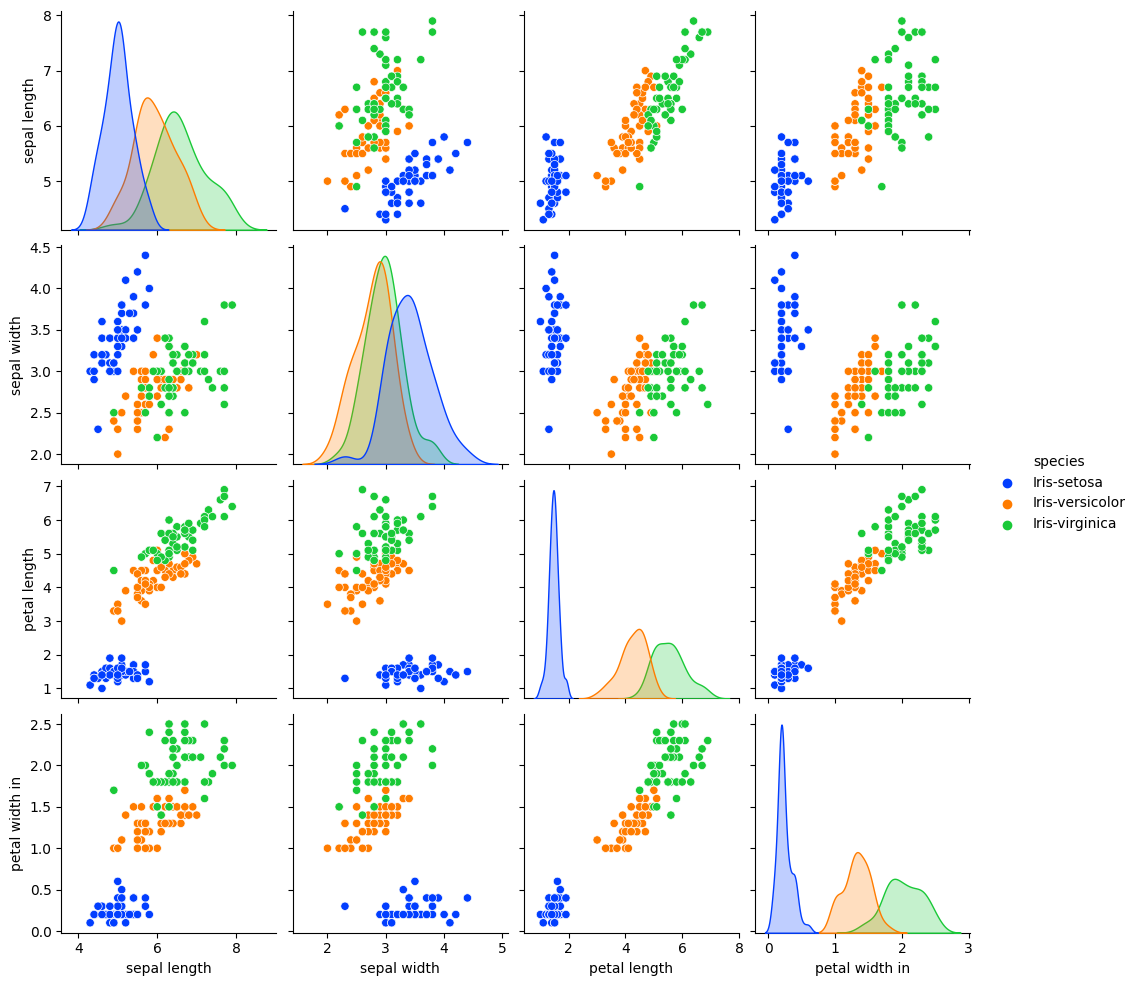

In [7]:
gt_clustdata = pd.read_csv("data/iris/iris.csv")
sns.pairplot(gt_clustdata, hue = "species", palette = "bright")